In [1]:
import pickle
import gzip
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import os
import numpy as np
np.random.seed(666)

from tensorflow import set_random_seed
set_random_seed(125)

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

from keras.datasets import mnist
import keras

from keras.layers import Conv2D,MaxPooling2D,Flatten
from sklearn.externals import joblib



Using TensorFlow backend.


In [2]:
def accuracy(test_data,test_target,model):
    correct = 0
    predicted = model.predict(test_data,verbose=True)
    left = np.array(np.argmax(predicted,axis=1)).flatten()
    right = np.argmax(test_target,axis=1)
    confusion_mat = np.zeros((10,10))
    for i in range(len(test_target)):
        if(left[i] == right[i]):
            correct+=1
        confusion_mat[right[i]][left[i]] =confusion_mat[right[i]][left[i]] +1
    return correct/len(test_target),pd.DataFrame(np.matrix(confusion_mat,dtype="int32"))

def more_metrics(conf_mat):
    true_positives = 0
    precision = []
    recall = []
    for i in range(len(conf_mat)):
        true_positives += conf_mat.iloc[i,i]
    conf_mat = np.matrix(conf_mat)
    tp_fp = np.array(np.sum(conf_mat,axis=1)).ravel()
    relevant_elements = np.array(np.sum(conf_mat,axis=0)).ravel()
    for i in range(len(conf_mat)):
        precision.append(conf_mat[i,i]/tp_fp[i])
        recall.append(conf_mat[i,i]/relevant_elements[i])
    return true_positives,precision,recall

In [3]:
filename = '../mnist.pkl.gz'
f = gzip.open(filename, 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
f.close()
train_data = np.append(training_data[0],validation_data[0],axis=0)
train_target = np.append(training_data[1],validation_data[1],axis=0)
train_target = keras.utils.to_categorical(train_target, 10)
test_target = keras.utils.to_categorical(test_data[1], 10)
test_data = test_data[0]

In [9]:
image_vector_size = 28* 28
train_data = train_data.reshape(train_data.shape[0], image_vector_size)
test_data = test_data.reshape(test_data.shape[0], image_vector_size)
num_classes =10

In [10]:
NNType = 'DNN'

if(NNType=='CNN'):
    print("Processing for CNN")
    filename = '../mnist.pkl.gz'
    f = gzip.open(filename, 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    num_classes = 10

    x_train = np.append(training_data[0],validation_data[0],axis=0)
    y_train = np.append(training_data[1],validation_data[1])
    x_test = test_data[0]
    y_test = test_data[1]

    img_x, img_y = 28, 28
    #(x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 1)
    x_test = x_test.reshape(x_test.shape[0], img_x, img_y, 1)
    input_shape = (img_x, img_y, 1)

    # convert the data to the right type
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    #print('x_train shape:', x_train.shape)
    #print(x_train.shape[0], 'train samples')
    #print(x_test.shape[0], 'test samples')

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

In [11]:
def baseline():
    model = Sequential()
    model.add(Dense(units=32, activation='sigmoid', input_shape=(image_vector_size,)))
    model.add(Dense(units=num_classes, activation='softmax'))
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

def highHidden():
    drop_out = 0.1
    model = Sequential()
    model.add(Dense(units=32,activation='sigmoid',input_shape=(image_vector_size,)))
    model.add(Activation('tanh'))
    model.add(Dense(128, input_dim=image_vector_size))
    model.add(Activation('relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(128, input_dim=image_vector_size))
    model.add(Dense(units=num_classes, activation='softmax'))

    #sgd = optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])    
    model.summary()
    return model

def lowHidden():
    model = Sequential()
    model.add(Dense(units=1024,activation='tanh',input_shape=(image_vector_size,)))
    model.add(Dense(2048,activation='relu',input_dim=image_vector_size))
    model.add(Dense(units=num_classes, activation='softmax'))

    #sgd = optimizers.SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])    
    model.summary()
    return model

def conv():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(20, 20), strides=(1, 1),activation='tanh',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

In [41]:
model = highHidden()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 32)                25120     
_________________________________________________________________
activation_5 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               4224      
_________________________________________________________________
activation_6 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_22 (Dense)             (None, 10)                1290      
Total para

In [36]:
if(NNType=='CNN'):
    print("Processing for CNN")
    filename = '../mnist.pkl.gz'
    f = gzip.open(filename, 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    num_classes = 10

    x_train = np.append(training_data[0],validation_data[0],axis=0)
    y_train = np.append(training_data[1],validation_data[1])
    x_test = test_data[0]
    y_test = test_data[1]

    img_x, img_y = 28, 28
    #(x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 1)
    x_test = x_test.reshape(x_test.shape[0], img_x, img_y, 1)
    input_shape = (img_x, img_y, 1)

    # convert the data to the right type
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    #print('x_train shape:', x_train.shape)
    #print(x_train.shape[0], 'train samples')
    #print(x_test.shape[0], 'test samples')

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, 
                                 patience=20, mode='auto')
    history = model.fit(x_train, y_train, 
                        batch_size=128,
                        epochs=150,
                        verbose=True,
                        validation_split=.1,
                        callbacks = [earlystopping_cb])

In [42]:
earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, 
                                 patience=5, mode='auto')

history = model.fit(train_data, train_target, 
                    batch_size=512, 
                    epochs=150,
                    verbose=True,
                    validation_split=.1,
                   callbacks = [earlystopping_cb])

Train on 54000 samples, validate on 6000 samples
Epoch 1/150
54000/54000 [==============================] - 1s 18us/step - loss: 1.0832 - acc: 0.6867 - val_loss: 0.3272 - val_acc: 0.9072
Epoch 2/150
54000/54000 [==============================] - 1s 9us/step - loss: 0.3505 - acc: 0.8966 - val_loss: 0.2378 - val_acc: 0.9317
Epoch 3/150
54000/54000 [==============================] - 1s 9us/step - loss: 0.2762 - acc: 0.9178 - val_loss: 0.1932 - val_acc: 0.9437
Epoch 4/150
54000/54000 [==============================] - 1s 9us/step - loss: 0.2338 - acc: 0.9300 - val_loss: 0.1722 - val_acc: 0.9512
Epoch 5/150
54000/54000 [==============================] - 1s 9us/step - loss: 0.2057 - acc: 0.9381 - val_loss: 0.1514 - val_acc: 0.9583
Epoch 6/150
54000/54000 [==============================] - 0s 9us/step - loss: 0.1820 - acc: 0.9461 - val_loss: 0.1398 - val_acc: 0.9620
Epoch 7/150
54000/54000 [==============================] - 1s 9us/step - loss: 0.1667 - acc: 0.9506 - val_loss: 0.1362 - val_acc

In [43]:
if(NNType=='CNN'):
    loss,acc = model.evaluate(x_train, y_train, verbose=True)
    print("The Loss for Training is: "+str(loss))
    print("The Accuracy for Training is: "+str(acc))
else:
    loss,acc = model.evaluate(train_data, train_target, verbose=True)
    print("The Loss for Training is: "+str(loss))
    print("The Accuracy for Training is: "+str(acc))

60000/60000 [==============================] - 1s 17us/step
The Loss for Training is: 0.04208651631673177
The Accuracy for Training is: 0.9879666666666667


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe0180700b8>,
      dtype=object)

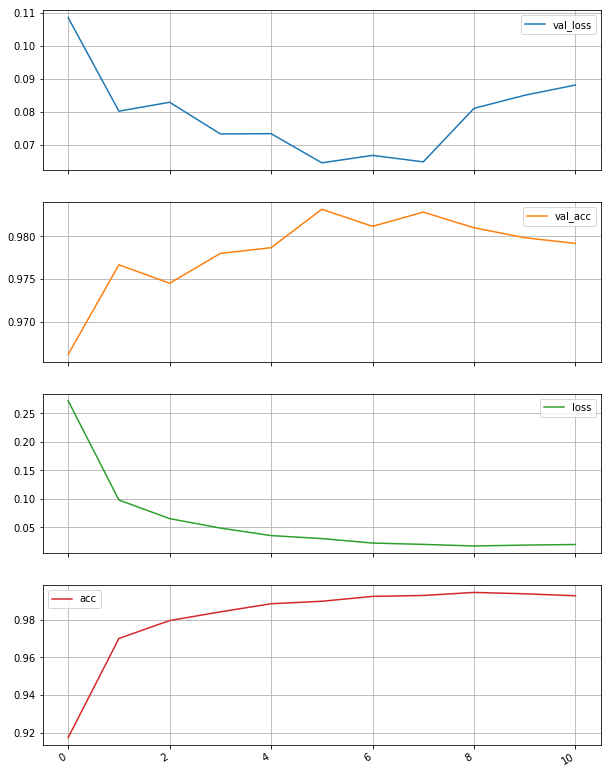

In [25]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

In [53]:
#joblib.dump(model,'./models/DNN_lowHidden.joblib',compress=True)
model = joblib.load('./models/DNN_lowHidden.joblib')

# Pre Process USPS

In [54]:
USPSMat  = []
USPSTar  = []
curPath  = '../USPSdata/Numerals'
savedImg = []

for j in range(0,10):
    curFolderPath = curPath + '/' + str(j)
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':
            img = Image.open(curImg,'r')
            img = img.resize((28, 28))
            savedImg = img
            imgdata = (255-np.array(img.getdata()))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)

In [55]:
if(NNType =='CNN'):
    print("Processing for CNN")
    USPSMat  = []
    USPSTar  = []
    curPath  = '../USPSdata/Numerals'
    savedImg = []

    for j in range(0,10):
        curFolderPath = curPath + '/' + str(j)
        imgs =  os.listdir(curFolderPath)
        for img in imgs:
            curImg = curFolderPath + '/' + img
            if curImg[-3:] == 'png':
                img = Image.open(curImg,'r')
                img = img.resize((28, 28))
                img = np.asarray(img)
                #savedImg = img
                #imgdata = (255-np.array(img.getdata()))/255
                USPSMat.append(img)
                USPSTar.append(j)
    USPSMat = np.asarray(USPSMat)
    USPSMat = USPSMat.reshape(USPSMat.shape[0], 28, 28, 1)

In [56]:
USPSTar = keras.utils.to_categorical(USPSTar, num_classes)

In [57]:
if(NNType =='CNN'):
    acc,conf_mat = accuracy(x_test,y_test,model)
    print("The Accuracy for Testing on MNIST is: "+str(acc))
    print("The Confusion Matrix is: ")
    print(conf_mat)
    _,precision,recall = more_metrics(pd.DataFrame(conf_mat))
    print("The Precision & Recall is: ")
    df = pd.DataFrame(np.multiply(precision,100))
    df.columns = ["Recall"]
    df1 = pd.DataFrame(np.multiply(recall,100))
    df1.columns = ["Precision"]
    print(pd.concat([df,df1],axis=1))
else:
    acc,conf_mat = accuracy(test_data,test_target,model)
    print("The Accuracy for Testing on MNIST is: "+str(acc))
    print("The Confusion Matrix is: ")
    print(conf_mat)
    _,precision,recall = more_metrics(pd.DataFrame(conf_mat))
    print("The Precision & Recall is: ")
    df = pd.DataFrame(np.multiply(precision,100))
    df.columns = ["Recall"]
    df1 = pd.DataFrame(np.multiply(recall,100))
    df1.columns = ["Precision"]
    print(pd.concat([df,df1],axis=1))

10000/10000 [==============================] - 1s 92us/step
The Accuracy for Testing on MNIST is: 0.9823
The Confusion Matrix is: 
     0     1     2    3    4    5    6     7    8    9
0  972     1     0    1    0    0    2     1    3    0
1    0  1129     1    2    0    1    0     2    0    0
2    2     1  1009    6    1    1    1     6    4    1
3    1     0     1  977    0   16    0     7    3    5
4    0     0     3    1  960    0    3     3    1   11
5    2     0     0    4    0  879    2     1    1    3
6    4     2     0    1    2    2  942     1    4    0
7    1     1     5    2    1    0    0  1012    4    2
8    0     0     2    5    2    3    1     5  952    4
9    0     0     0    1    7    5    1     1    3  991
The Precision & Recall is: 
      Recall  Precision
0  99.183673  98.981670
1  99.471366  99.559083
2  97.771318  98.824682
3  96.732673  97.700000
4  97.759674  98.663926
5  98.542601  96.912900
6  98.329854  98.949580
7  98.443580  97.401347
8  97.741273  97.641

In [58]:
acc,conf_mat = accuracy([USPSMat],USPSTar,model)
print("The Accuracy for Testing on USPS is: "+str(acc))
print("The Confusion Matrix is: ")
print(conf_mat)
_,precision,recall = more_metrics(pd.DataFrame(conf_mat))
print("The Precision & Recall is: ")
df = pd.DataFrame(np.multiply(precision,100))
df.columns = ["Recall"]
df1 = pd.DataFrame(np.multiply(recall,100))
df1.columns = ["Precision"]
print(pd.concat([df,df1],axis=1))

19999/19999 [==============================] - 2s 81us/step
The Accuracy for Testing on USPS is: 0.5060753037651883
The Confusion Matrix is: 
     0    1     2     3     4     5     6    7    8    9
0  836    4    66    93   186   154   111  150   91  309
1   71  575   144   144   321   131    91  349   92   82
2   54    4  1548    86    13    86    79   57   66    6
3   13    4    71  1465     3   347     6   21   61    9
4   32   71    30    23  1002   129    34  320  301   58
5   54    3    58    68     5  1647    15   55   82   13
6  116   15   201    44    38   224  1203   40   69   50
7   47  233   216   566    31    50     6  690  149   12
8  150   12    90   328    69   362    50   87  825   27
9   37  104    54   260   139    93     6  659  318  330
The Precision & Recall is: 
      Recall  Precision
0  41.800000  59.290780
1  28.750000  56.097561
2  77.438719  62.469734
3  73.250000  47.611310
4  50.100000  55.451024
5  82.350000  51.101458
6  60.150000  75.140537
7  34.50000